In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  cat  frog   dog horse


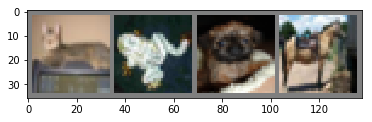

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.145
[1,  4000] loss: 1.826
[1,  6000] loss: 1.662
[1,  8000] loss: 1.579
[1, 10000] loss: 1.522
[1, 12000] loss: 1.480
[2,  2000] loss: 1.406
[2,  4000] loss: 1.378
[2,  6000] loss: 1.359
[2,  8000] loss: 1.323
[2, 10000] loss: 1.328
[2, 12000] loss: 1.295
[3,  2000] loss: 1.231
[3,  4000] loss: 1.211
[3,  6000] loss: 1.213
[3,  8000] loss: 1.185
[3, 10000] loss: 1.196
[3, 12000] loss: 1.194
[4,  2000] loss: 1.129
[4,  4000] loss: 1.115
[4,  6000] loss: 1.116
[4,  8000] loss: 1.122
[4, 10000] loss: 1.112
[4, 12000] loss: 1.119
Finished Training


('GroundTruth: ', '  cat  ship  ship plane')


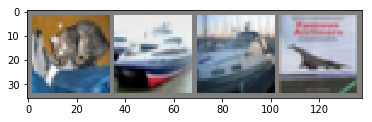

In [6]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

('Predicted: ', '  cat  ship   car plane')


In [31]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


In [23]:
lol = net.state_dict()

In [7]:
class oSample(torch.autograd.Function):
    def forward(ctx, inputs):
        delt = 1*pow(2,-5)
        M = (inputs/delt).round()
        M[M>=128] = 127
        M[M<-127] = -128
        S = delt*M
        return S
    def backward(ctx, g):
        return g

def sampleStateDict(net):
    Dict = net.state_dict()
    Key = Dict.keys()
    for i in Key:
        Dict[i] = oSample()(Dict[i])
    net.load_state_dict(Dict)

def protectStateDict(net):
    Dict = net.state_dict()
    Key = Dict.keys()
    for i in Key:
        Dict[i] = Dict[i]*1
    return Dict

In [13]:
class SampleNet(nn.Module):
    def __init__(self):
        super(SampleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = oSample()(self.pool(oSample()(F.relu(oSample()(self.conv1(x))))))
        x = oSample()(self.pool(oSample()(F.relu(oSample()(self.conv2(x))))))
        x = x.view(-1, 16 * 5 * 5)
        x = oSample()(F.relu(oSample()(self.fc1(x))))
        x = oSample()(F.relu(self.fc2(x)))
        x = oSample()(self.fc3(x))
        return x


sample_net = SampleNet()

In [28]:
sample_net.load_state_dict(lol)
sampleStateDict(sample_net)

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = sample_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 32 %


In [14]:
criterion_s = nn.CrossEntropyLoss()
optimizer_s = optim.SGD(sample_net.parameters(), lr=0.01, momentum=0.9)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer_s.zero_grad()

        # forward + backward + optimize
        TMP = protectStateDict(sample_net)
        sampleStateDict(sample_net)
        outputs = sample_net(inputs)
        loss = criterion_s(outputs, labels)
        loss.backward()
        sample_net.load_state_dict(TMP)
        optimizer_s.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.108
[1,  4000] loss: 1.981
[1,  6000] loss: 1.958
[1,  8000] loss: 2.037
[1, 10000] loss: 2.029
[1, 12000] loss: 2.029
[2,  2000] loss: 2.061
[2,  4000] loss: 2.067
[2,  6000] loss: 2.050
[2,  8000] loss: 2.065
[2, 10000] loss: 2.085
[2, 12000] loss: 2.066
Finished Training
